# Monte Carlo Integration and Importance Sampling
Some experiments and notes to work along [Ray Tracing - The Rest of Your Life](https://raytracing.github.io/books/RayTracingTheRestOfYourLife.html).

Classifying random algorithms:
* **Monte Carlo:** randomize the outcome (outcome is approximately correct), runtime is deterministic
* **Las Vegas:** randomize the runtime, outcome is deterministic (and correct, of course)

## Preamble

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

## Monte Carlo estimation of Pi
To estimate Pi, we can inscribe a circle with unit radius (area $\pi r^2 = \pi$) into a square of side length 2 (area $4$). The ratio of their areas are $\pi / 4$, thus, when sampling points uniformly at random inside the square, we expect that a fraction of $\pi / 4$ land inside the sphere.

We try both **non-stratified** sampling, where the points are sampled uniformly at random, and **stratified** sampling, in which the points are distributed more evenly as they are sampled inside equally sized grid cells across the cube. We would expect stratified sampling to show faster convergence.

In [41]:
def sample_in_unit_cube(number_of_samples):
    """Sample a square with corners at (0,0), (1,1,) uniformly at random."""
    return np.random.random_sample((2, number_of_samples))

def sample_in_cube(number_of_samples, side=2):
    """Sample a (centered) square with given `side` length uniformly at random."""
    return side * sample_in_unit_cube(number_of_samples) - side / 2

def sample_in_cube_stratified(number_of_samples, side=2):
    """Sample a (centered) square stratified."""
    # specify grid for stratification
    number_of_columns = int(np.sqrt(number_of_samples))
    cell_side = side / number_of_columns

    # non-stratified samples, all in first grid cell
    samples = cell_side * sample_in_unit_cube(number_of_samples) - side / 2

    # shift each sample to its grid cell, note that the input is of shape (2, -1)
    stratified = samples.transpose((1,0)).reshape((-1, number_of_columns, 2))
    x_shifts = np.linspace(0, side, stratified.shape[1], endpoint=False)
    y_shifts = np.linspace(0, side, stratified.shape[0], endpoint=False)
    shifts = np.stack(np.meshgrid(x_shifts, y_shifts), axis=-1)
    stratified = stratified + shifts
    return stratified.reshape((-1,2)).transpose((1,0))

def is_inside_sphere(samples, radius=1):
    """Test if samples fall within a (centered) circle of given `radius`."""
    return (samples**2).sum(axis=0) < radius**2

def draw_circle(ax, radius=1):
    """Add a (centered) circle to the matplotlib axis `ax`."""
    x = np.linspace(0, 2*np.pi, 100)
    ax.plot(radius * np.cos(x), radius * np.sin(x))



non-stratified (top) vs stratified sampling (bottom)


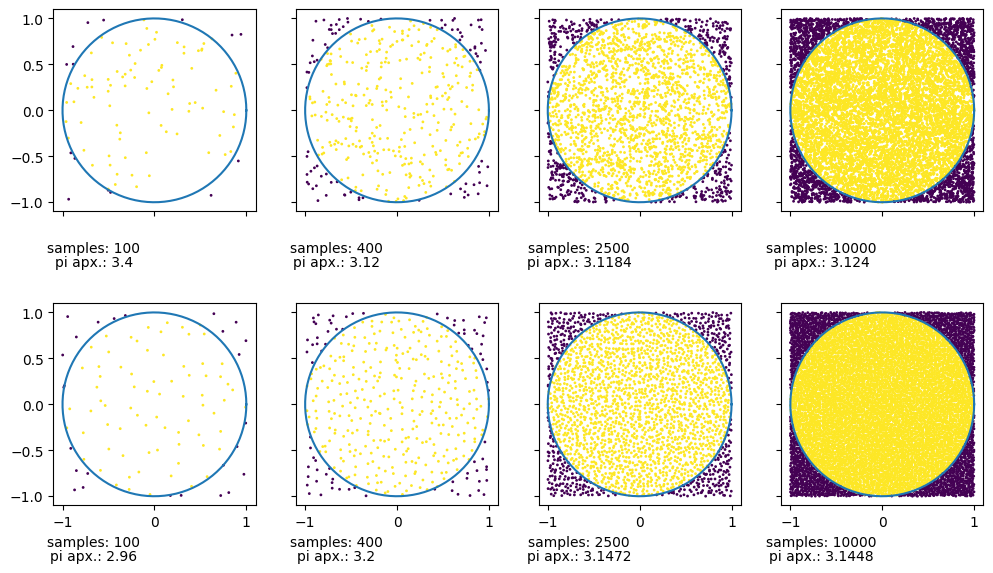

In [46]:
print("non-stratified (top) vs stratified sampling (bottom)")
numbers_of_samples = [10**2, 20**2, 50**2, 100**2]
fig, axs = plt.subplots(nrows=2, ncols=len(numbers_of_samples), figsize=(12, 7), sharex=True, sharey=True)

def evaluate_experiment_and_plot(samples, axis):
    # estimate pi
    inside_sphere = is_inside_sphere(samples)
    pi_apx = 4 * inside_sphere.sum() / len(inside_sphere)
    # plot
    axis.set_aspect('equal')
    axis.scatter(samples[0], samples[1], c=inside_sphere, s=1)
    draw_circle(axis)
    axis.text(0.2, -0.2, 'samples: ' + str(number_of_samples), ha='center', transform=axis.transAxes)
    axis.text(0.2, -0.27, 'pi apx.: ' + str(pi_apx), ha='center', transform=axis.transAxes)


for number_of_samples, ax in zip(numbers_of_samples, axs.transpose((1,0))):
    evaluate_experiment_and_plot(sample_in_cube(number_of_samples), ax[0])
    evaluate_experiment_and_plot(sample_in_cube_stratified(number_of_samples), ax[1])

In this case, stratification (bottom row) indeed shows faster convergence.